In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import igraph

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.0 anndata==0.7.5 umap==0.5.1 numpy==1.20.1 scipy==1.5.3 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [3]:
results_file = 'write/210323.h5ad' 

In [4]:
adata = sc.read_10x_mtx(
    '/mnt/d/Nishino/DRY/data/analysis/JAGGED1/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/mnt-d-Nishino-DRY-data-analysis-JAGGED1-filtered_feature_bc_matrix-matrix.h5ad


In [5]:
adata.var_names_make_unique()

In [6]:
adata

AnnData object with n_obs × n_vars = 8862 × 32285
    var: 'gene_ids', 'feature_types'

normalizing counts per cell
    finished (0:00:00)


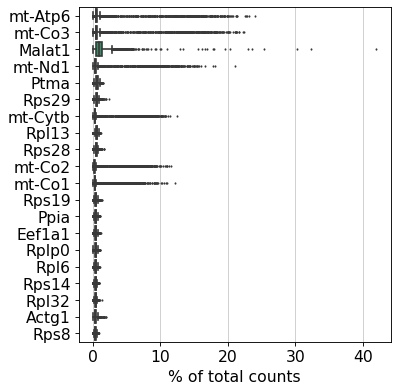

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=6)

filtered out 121 cells that have less than 200 genes expressed
filtered out 13505 genes that are detected in less than 6 cells


In [9]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
adata.var['ribo'] = adata.var_names.str.startswith(('Rps','Rpl')) 
adata.var['hb'] = adata.var_names.str.startswith(('Hba','Hbb')) 

In [10]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['hb'], percent_top=None, log1p=False, inplace=True)

... storing 'feature_types' as categorical


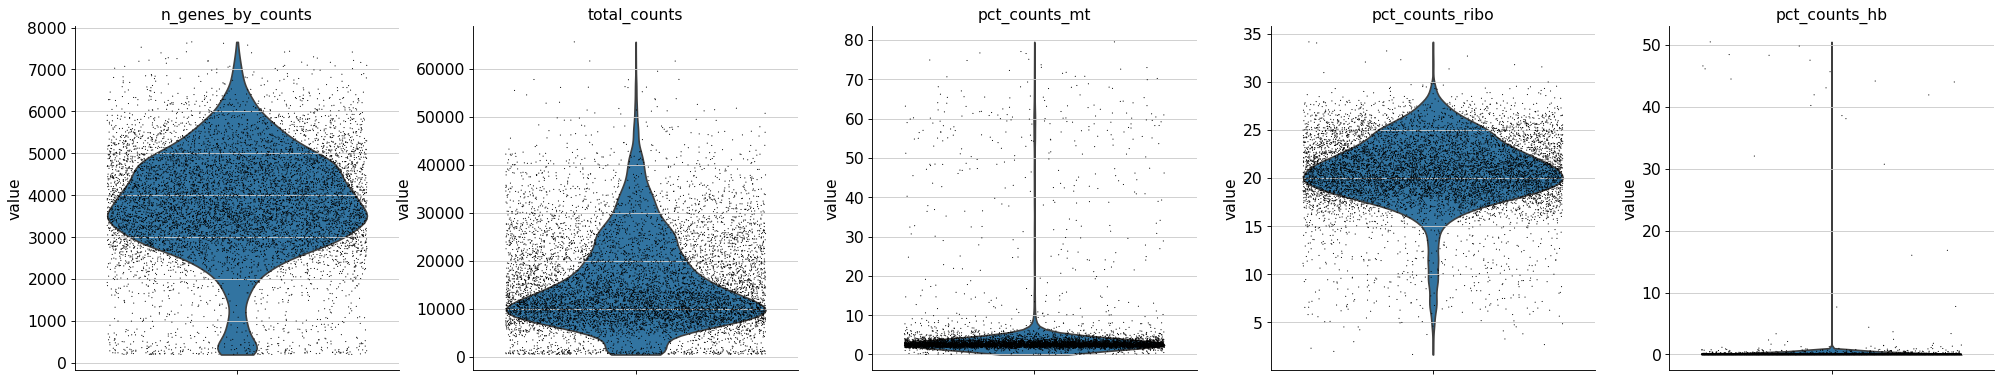

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, multi_panel=True)

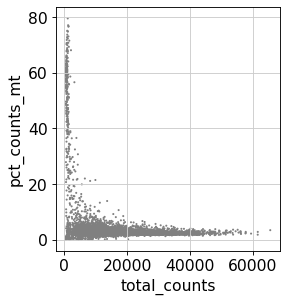

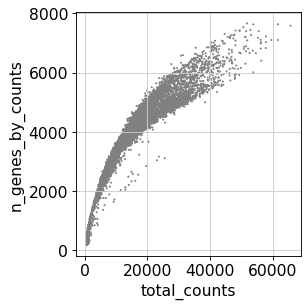

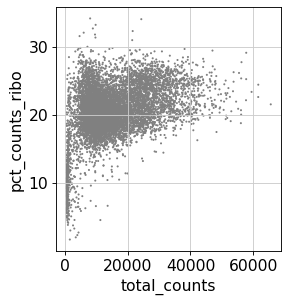

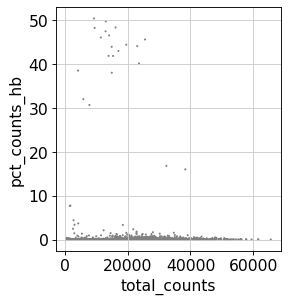

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_hb')

In [13]:
adata = adata[adata.obs.pct_counts_mt < 10, :]
adata = adata[adata.obs.pct_counts_ribo > 15, :]

/home/analysis/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/analysis/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [14]:
adata

View of AnnData object with n_obs × n_vars = 8269 × 18780
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

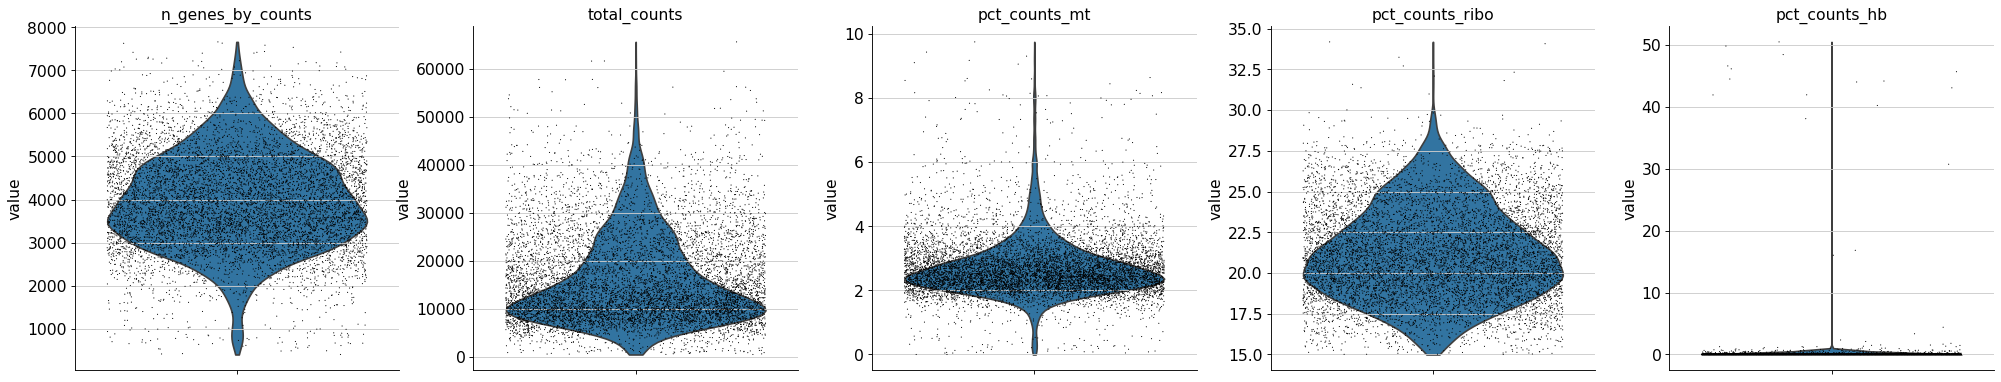

In [15]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, multi_panel = True)

In [16]:
malat1 = adata.var_names.str.startswith('Malat1')
mito_genes = adata.var_names.str.startswith('mt-')
ribo_genes = adata.var_names.str.startswith(('Rps','Rpl'))
hb_genes = adata.var_names.str.startswith(('Hba', 'Hbb'))

remove = np.add(mito_genes, malat1)
remove = np.add(remove, ribo_genes)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

8269 18658


/home/analysis/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [17]:
adata.raw = adata
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 2.6%
Estimated detectable doublet fraction = 39.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.4%
Elapsed time: 7.4 seconds


211

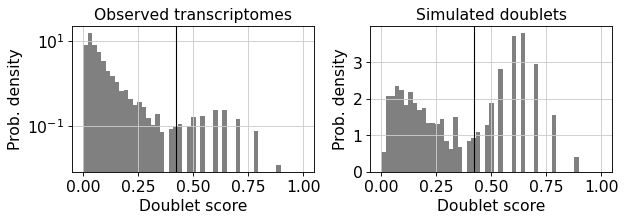

In [18]:
import scrublet as scr
scrub = scr.Scrublet(adata.raw.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])

In [19]:
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

... storing 'doublet_info' as categorical


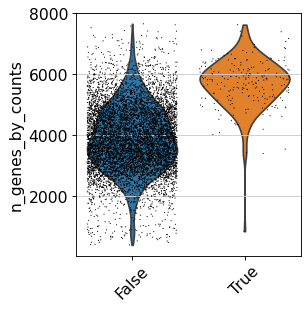

In [20]:
sc.pl.violin(adata, 'n_genes_by_counts',
             jitter=0.4, groupby = 'doublet_info', rotation=45)

In [21]:
adata

AnnData object with n_obs × n_vars = 8269 × 18658
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_counts', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'doublet_info_colors'

In [22]:
adata = adata.raw.to_adata() 

adata = adata[adata.obs['doublet_info'] == 'False',:]
print(adata.shape)

(8058, 18658)


/home/analysis/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [23]:
adata.write(results_file)